In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import random
from glob import glob
from PIL import Image

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
#import autokeras as ak

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [93]:
metadata_df = pd.read_csv('Data/HAM10000_metadata.csv')

In [94]:
#Previewing metasata for images in dataset  dx is the type of cancer 
metadata_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern


In [95]:
print(metadata_df['dx'].unique())
print(metadata_df['dx'].value_counts())
# as it seems there some types has much propabability to happen than others

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [96]:
lblen = LabelEncoder()
lblen.fit(metadata_df['dx'])
print(list(lblen.classes_))

metadata_df['label'] = lblen.transform(metadata_df["dx"]) 

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [97]:
# Show sample of the data with label
metadata_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
3755,HAM_0000205,ISIC_0029471,nv,follow_up,35.0,female,trunk,vidir_molemax,5
2947,HAM_0006049,ISIC_0031614,bcc,histo,45.0,female,back,rosendahl,1
399,HAM_0004945,ISIC_0029358,bkl,histo,85.0,male,back,rosendahl,2
5868,HAM_0000914,ISIC_0025995,nv,follow_up,35.0,female,trunk,vidir_molemax,5
3134,HAM_0003788,ISIC_0026246,nv,follow_up,45.0,female,lower extremity,vidir_molemax,5


In [126]:
## Balancing Data
# from sklearn.utils import resample

# df_0 =metadata_df[metadata_df['label'] == 0]
# df_1 =metadata_df[metadata_df['label'] == 1]
# df_2 =metadata_df[metadata_df['label'] == 2]
# df_3 =metadata_df[metadata_df['label'] == 3]
# df_4 =metadata_df[metadata_df['label'] == 4]
# df_5 =metadata_df[metadata_df['label'] == 5]
# df_6 =metadata_df[metadata_df['label'] == 6]

# n_samples=250 
# df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
# df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
# df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
# df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
# df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
# df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
# df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

# #Combined back to a single dataframe
# metadata_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
#                               df_2_balanced, df_3_balanced, 
#                               df_4_balanced, df_5_balanced, df_6_balanced])

# #Check the distribution. All classes should be balanced now.
# print(metadata_df_balanced['dx'].value_counts())
# print(metadata_df_balanced.duplicated().sum())

#metadata_df_balanced

In [127]:
#metadata_df_balanced.query("dx =='mel'").duplicated().sum()

In [99]:
# Reading Images associated with each class
#The glob module finds all the pathnames matching a specified pattern according
#to the rules used by the Unix shell, although results are returned in arbitrary order

SIZE = 160  #pixel*pixel

image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob('Data/HAM10000_Dataset/**/*.jpg', recursive= True)}
#glob('Data/HAM10000_Dataset/**/*.jpg',recursive=True)  Give u all the pathes ends with .jpg

# make a new column with the path of the image associated with each class

metadata_df['path'] = metadata_df['image_id'].map(image_path.get)
#metadata_df_balanced['image'] = metadata_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

metadata_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,path
5309,HAM_0003134,ISIC_0027001,nv,follow_up,40.0,female,trunk,vidir_molemax,5,Data/HAM10000_Dataset\ISIC_0027001.jpg
8574,HAM_0000284,ISIC_0025597,nv,histo,50.0,female,lower extremity,rosendahl,5,Data/HAM10000_Dataset\ISIC_0025597.jpg
4950,HAM_0004229,ISIC_0029593,nv,follow_up,40.0,male,trunk,vidir_molemax,5,Data/HAM10000_Dataset\ISIC_0029593.jpg
9271,HAM_0003579,ISIC_0028042,nv,consensus,60.0,male,back,vidir_modern,5,Data/HAM10000_Dataset\ISIC_0028042.jpg
5766,HAM_0002687,ISIC_0032037,nv,follow_up,60.0,female,back,vidir_molemax,5,Data/HAM10000_Dataset\ISIC_0032037.jpg


In [124]:
#make folder name for each class
import shutil
bkl_path = 'Data/HAM10000_Dataset/bkl'
nv_path = 'Data/HAM10000_Dataset/nv'
akiec_path = 'Data/HAM10000_Dataset/akiec'
bcc_path = 'Data/HAM10000_Dataset/bcc'
df_path = 'Data/HAM10000_Dataset/df'
mel_path = 'Data/HAM10000_Dataset/mel'
vasc_path = 'Data/HAM10000_Dataset/vasc'

Im_Id = metadata_df['image_id']
Dx = metadata_df['dx']

In [125]:
for index, pth in enumerate(metadata_df['path']):  # enumerate to get index in each loop
    if Dx[index] == 'bkl':
        if not os.path.isdir(bkl_path):
            os.mkdir(bkl_path)
        shutil.move(pth, bkl_path)
    elif Dx[index] == 'nv':
        if not os.path.isdir(nv_path):
            os.mkdir(nv_path)
        shutil.move(pth, nv_path)
    elif Dx[index] == 'akiec':
        if not os.path.isdir(akiec_path):
            os.mkdir(akiec_path)
        shutil.move(pth, akiec_path) 
    elif Dx[index] == 'bcc':
        if not os.path.isdir(bcc_path):
            os.mkdir(bcc_path)
        shutil.move(pth, bcc_path)
    elif Dx[index] == 'df':
        if not os.path.isdir(df_path):
            os.mkdir(df_path)
        shutil.move(pth, df_path)
    elif Dx[index] == 'mel':
        if not os.path.isdir(mel_path):
            os.mkdir(mel_path)
        shutil.move(pth, mel_path)
    elif Dx[index] == 'vasc':
        if not os.path.isdir(vasc_path):
            os.mkdir(vasc_path)
        shutil.move(pth, vasc_path)
    
    
        
    #print(os.path.split(pth)[0].replace('Dataset','bahaa'))

In [8]:
# seed must be equal for both training and validation not to overlap.
BATCH_SIZE = 32
IMG_SIZE = (160, 160)  # resolution
directory = "Data/Dataset-Balnced-Manual/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             label_mode='categorical',
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 9895 files belonging to 7 classes.
Using 7916 files for training.
Found 9895 files belonging to 7 classes.
Using 1979 files for validation.


In [17]:
nv = 6705
mel = 1113
bkl = 1099
bcc = 514
akiec = 327
vasc = 142
df = 115

total = nv + mel + bkl + bcc + akiec + vasc + df

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / akiec) * (total / 7.0)
weight_for_1 = (1 / bcc) * (total / 7.0)
weight_for_2 = (1 / bkl) * (total / 7.0)
weight_for_3 = (1 / df) * (total / 7.0)
weight_for_4 = (1 / mel) * (total / 7.0)
weight_for_5 = (1 / nv) * (total / 7.0)
weight_for_6 = (1 / vasc) * (total / 7.0)



class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3,
                4: weight_for_4, 5: weight_for_5, 6: weight_for_6}

print('Weight for class 1: {:.2f}'.format(weight_for_0))
print('Weight for class 2: {:.2f}'.format(weight_for_1))
print('Weight for class 3: {:.2f}'.format(weight_for_2))
print('Weight for class 4: {:.2f}'.format(weight_for_3))
print('Weight for class 5: {:.2f}'.format(weight_for_4))
print('Weight for class 6: {:.2f}'.format(weight_for_5))
print('Weight for class 7: {:.2f}'.format(weight_for_6))

#These will cause the model to "pay more attention" to examples from an under-represented class.
#The more data class have, the less weight they have

Weight for class 1: 4.38
Weight for class 2: 2.78
Weight for class 3: 1.30
Weight for class 4: 12.44
Weight for class 5: 1.29
Weight for class 6: 0.21
Weight for class 7: 10.08


In [18]:
class_names = train_dataset.class_names
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

InvalidArgumentError: assertion failed: [Unable to decode bytes as JPEG, PNG, GIF, or BMP]
	 [[{{node decode_image/cond_jpeg/else/_1/decode_image/cond_jpeg/cond_png/else/_20/decode_image/cond_jpeg/cond_png/cond_gif/else/_39/decode_image/cond_jpeg/cond_png/cond_gif/Assert/Assert}}]]

<Figure size 720x720 with 0 Axes>

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# prevents a memory bottleneck that can occur when reading from disk

In [20]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input #data preprocessing using the same weights the model was trained on

In [21]:
# MobileNet V2 trained on imagenet data
IMG_SHAPE = IMG_SIZE + (3,) # as Img size 160*160 only but we need it 160*160*3 for the model
base_model = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [22]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

post_bn
post_relu


In [23]:
# Create the breast cancer model
def BC_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # Create the model with its weights without the top layers
     
    base_model.trainable = False  # not to train any of the base model and train only the new layers will be added
    inputs = tf.keras.Input(shape=input_shape)
    
    #x = data_augmentation(inputs) # augmenting the input
    
    x = preprocess_input(inputs) #data preprocessing using the same weights the model was trained on
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.25)(x)
    prediction_layer = tfl.Dense(7, activation='softmax') 
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    print(model.summary())
    return model

In [24]:
BCModel = BC_model(IMG_SIZE)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [25]:
base_learning_rate = 0.01
BCModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
initial_epochs = 5
#Add class weigths 
history = BCModel.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs,
                      use_multiprocessing= True, class_weight=class_weight,
                      callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2))

Epoch 1/5
251/251 [==============================] - 613s 2s/step - loss: 3.9697 - accuracy: 0.4381 - val_loss: 3.0194 - val_accuracy: 0.5592
Epoch 2/5
251/251 [==============================] - 594s 2s/step - loss: 2.7058 - accuracy: 0.5392 - val_loss: 3.3962 - val_accuracy: 0.4578
Epoch 3/5
251/251 [==============================] - 601s 2s/step - loss: 2.5802 - accuracy: 0.5721 - val_loss: 3.8242 - val_accuracy: 0.4778
Epoch 4/5
251/251 [==============================] - 622s 2s/step - loss: 2.2397 - accuracy: 0.5836 - val_loss: 3.1129 - val_accuracy: 0.5801
Epoch 5/5
251/251 [==============================] - 609s 2s/step - loss: 2.5208 - accuracy: 0.5856 - val_loss: 2.7318 - val_accuracy: 0.6021


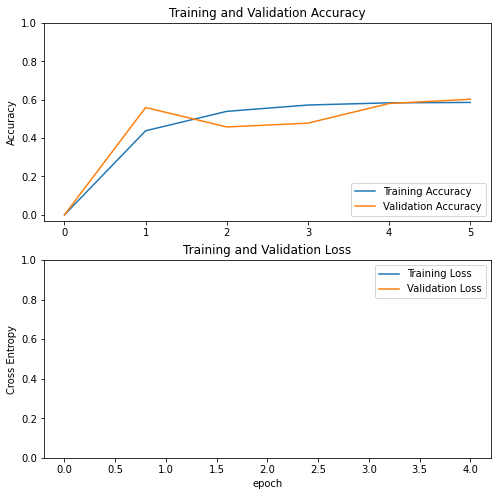

In [28]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# Make it trainable from specified layer number
base_model.trainable = True # Make all trainable as a start
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  377


In [64]:
fine_tune_at = 320 # Number to choose

for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= 'categorical_crossentropy'
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

BCModel.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [65]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = BCModel.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], 
                           validation_data=validation_dataset, class_weight=class_weight, 
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2))

Epoch 5/10
251/251 [==============================] - 669s 3s/step - loss: 1.5103 - accuracy: 0.6616 - val_loss: 1.9825 - val_accuracy: 0.6335
Epoch 6/10
251/251 [==============================] - 657s 3s/step - loss: 1.3166 - accuracy: 0.6735 - val_loss: 1.8784 - val_accuracy: 0.6505
Epoch 7/10
251/251 [==============================] - 611s 2s/step - loss: 1.2160 - accuracy: 0.6829 - val_loss: 2.1766 - val_accuracy: 0.5901
Epoch 8/10
251/251 [==============================] - 629s 3s/step - loss: 1.0321 - accuracy: 0.7016 - val_loss: 2.1900 - val_accuracy: 0.5801
Epoch 9/10
251/251 [==============================] - 650s 3s/step - loss: 0.9928 - accuracy: 0.6882 - val_loss: 1.8930 - val_accuracy: 0.6201
Epoch 10/10
251/251 [==============================] - 623s 2s/step - loss: 0.9962 - accuracy: 0.6955 - val_loss: 1.5516 - val_accuracy: 0.6830


In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

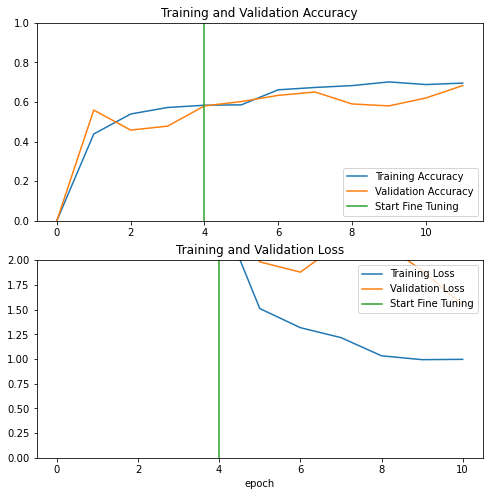

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.summary()

In [68]:
BCModel.evaluate(validation_dataset)

63/63 [==============================] - 119s 2s/step - loss: 1.5516 - accuracy: 0.6830


[1.5516170263290405, 0.6829755306243896]

In [69]:
BCModel.evaluate(train_dataset)

  9/251 [>.............................] - ETA: 6:22 - loss: 0.8343 - accuracy: 0.7465

KeyboardInterrupt: 

In [80]:
folder_dir = 'Data/Test/nv/'
predicts = []
for img in os.listdir(folder_dir):
    img_width, img_height = 160, 160
    img = tf.keras.preprocessing.image.load_img(os.path.join(folder_dir,img), target_size = (img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    array_probs = BCModel.predict(img)
    predicts.append(class_names[np.where(array_probs == np.amax(array_probs))[1][0]])


In [197]:
#for img,labels in train_dataset:
    #plt.imshow(imgs.numpy().astype("uint8"))
    #detect = list(labels[11].numpy())
    #print(class_names[detect.index(max(detect))])
 #  img = np.expand_dims(img, axis = 0)
    #print(img)
    #list_probs = list(BCModel.predict(img))
    #print(class_names[list_probs.index(max(list_probs))])

In [84]:
predicts.count('nv')

217

In [85]:
BCModel.save('BalancedDataModel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: BalancedDataModel\assets
